# Dates - Fake Covid-19 dataset

In order to create the bar and area charts, we need the following packages:

In [ ]:
from collections import Counter
import pandas as pd
from dateutil.parser import parse
import datetime
import json
import itertools  
import nltk
import altair as alt
import csv
from dateutil.parser import parse

To read the JSON file that has all the tweets, it is necessary to do:

In [ ]:
data = []
with open('dataset/fakecovid_result_final_translated_full.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))

## Bar chart: "Number of Tweets per day of the week"

We're interested in the "created_at" field:

In [ ]:
index = 0
new = []
for element in data:
    token = data[index]['created_at']
    new.append(token[0:3])
    index = index + 1

#print(new)
#print(len(new))

count_w = Counter(new)
#print(count)

The bar chart is created:

In [ ]:
df_w = pd.DataFrame.from_dict(count_w, orient='index').reset_index()
df_w = df_w.rename(columns={'index':'Day',0:'Tweet count'})

#range=['#e5c9fe','#c990ff','#b15fff','#992eff','#8100fc','#6800cc','#4f009b','#36006a','#1d0039']
chart = alt.Chart(df_w).mark_bar().encode(
    x = alt.X('Tweet count:Q'),
    y = alt.Y('Day', sort = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']),
    color=alt.Color('Tweet count:Q',scale=alt.Scale(scheme="purples")),
    tooltip=[
        alt.Tooltip('Day', title='Day'),
        alt.Tooltip('Tweet count:Q', title='Tweet count')
    ]
).transform_window( 
    rank='rank(count)',
    sort=[alt.SortField('count', order='descending')]
).properties(width=700, height=300,  title = "Number of Tweets per day of the week").configure_title(
    fontSize=17,
    offset=25
).configure_axis(
    labelFontSize=13,
    titleFontSize=15,
    titlePadding=15
).configure_legend(
    gradientThickness=20,
    titleFontSize=15,
    labelFontSize=13,
    titlePadding=10
)

chart

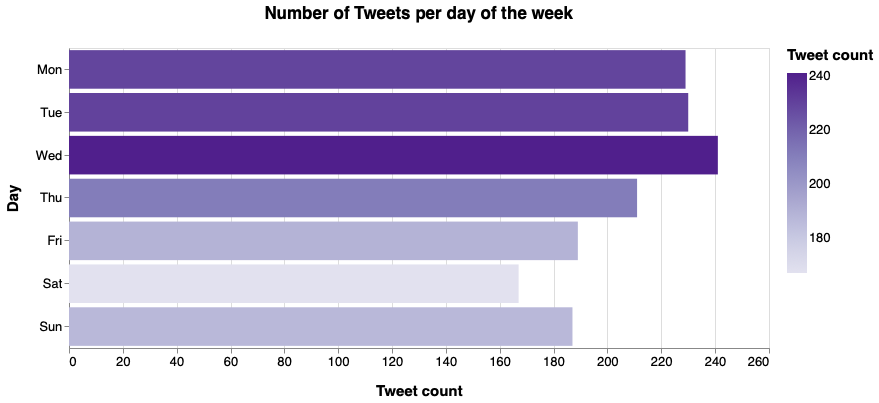

## Area chart: "Number of Tweets during the year"

We're interested in the "created_at" field:

In [ ]:
index = 0
new = []
for element in data:
    token = data[index]['created_at']
    d = parse(token)
    d = d.strftime('%Y/%m/%d')
    #new.append(token[4:7])
    new.append(d)
    index = index + 1

#print(new)
#print(len(new))

count = Counter(new)
#print(count)

The area chart is created:

In [ ]:
df = pd.DataFrame.from_dict(count, orient='index').reset_index()
df = df.rename(columns={'index':'Month',0:'Tweet count'})

df['Month']= pd.to_datetime(df['Month'])

# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['Month'], empty='none')


chart = alt.Chart(df).mark_area(
    #point= True,
    line={'color':'#126DC5'},
    color=alt.Gradient(
        gradient='linear',
        stops=[alt.GradientStop(color='white', offset=0),
               alt.GradientStop(color='mediumturquoise', offset=1)],
        x1=1,
        x2=1,
        y1=1,
        y2=0
    )
).properties(width=700, height=300,  title = "Number of Tweets during the year").encode(
    #alt.X('Month', sort = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug']),
    alt.X('Month'),
    alt.Y('Tweet count:Q')
    #tooltip=['Month', 'Tweet count']
)

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart(df).mark_point().encode(
    #x=alt.X('Month', sort = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug']),
    x=alt.X('Month'),
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = chart.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = chart.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'Tweet count:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(df).mark_rule(color='gray').encode(
    #x=alt.X('Month', sort = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug']),
     x=alt.X('Month'),
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
alt.layer(
    chart, selectors, points, rules, text
).properties(
    width=700, height=300
).configure_title(
    fontSize=17,
    offset=25
).configure_axis(
    labelFontSize=13,
    titleFontSize=15,
    titlePadding=15
)

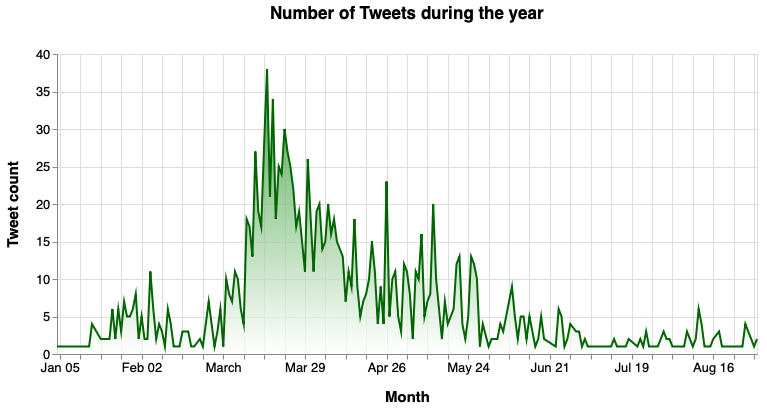

## Multi-Line Chart: number of tweets created each month and classified by their category

Here the goal is still to create a multi-line chart that shows the trend of the number of tweets created during the year (grouped by month) but here we are going to visualize two lines: one for the FALSE tweets and one for the PARTIALLY FALSE tweets.

In [ ]:
csv_dataframe = pd.read_csv('dataset/FINAL_fakecovid_final_filtered_dataset_clean.csv',sep=";")
csv_dataframe['tweet_id'] = csv_dataframe['tweet_id'].astype(str)
csv_list = csv_dataframe.values.tolist()
lista_unica_csv=list(itertools.chain.from_iterable(csv_list))


index=0
cmt_list = [] 
for element in data:
    token_id = data[index]['id_str']
    indice_csv = lista_unica_csv.index(token_id)
    token = data[index]['created_at']
    d = parse(token)
    d = d.strftime('%Y/%m/%d')
    #final_token = token[4:7] + " " +lista_unica_csv[indice_csv+1].lower().replace(" ", "")
    final_token = d + " " +lista_unica_csv[indice_csv+1].lower().replace(" ", "")
    
    cmt_list.append(final_token)
    index=index+1
    
fdist = dict(nltk.FreqDist(cmt_list))
df = pd.DataFrame.from_dict(fdist, orient='index').reset_index()
df = df.rename(columns={'index':'Month', 0:'count'})

Once the dataset is created, we work on it to create a better visualisation:

In [ ]:
col_one_list = df['Month'].tolist()
col_two_list = df['count'].tolist()

typelist=[]
namelist=[]

index = 0

count_false = [0] * len(col_one_list)
count_part = [0] * len(col_one_list)

for el in col_one_list:
    tok = el.split()
    namelist.append(tok[0])
    #typelist.append(tok[1])
    if tok[0] in namelist:
        indx = namelist.index(tok[0])
        if tok[1] == "false":
            count_false[indx] = col_two_list[index]
        elif tok[1] == "partiallyfalse":
            count_part[indx] = col_two_list[index]
        else:
            print("errore")
   
    index = index + 1

df['Month']=namelist
df['False Tweets']=count_false
df['Partially False Tweets']=count_part
del df['count'] #clean column
df['count'] = df['False Tweets'] + df['Partially False Tweets']

df['Month']= pd.to_datetime(df['Month'])
#print(df.to_string())

Plot the chart:

In [ ]:
# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['Month'], empty='none')



lines = alt.Chart(df).transform_fold(
    ['False Tweets', 'Partially False Tweets'],
).mark_line().encode(
    #x=alt.X('month:N', sort = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug']),
    x=alt.X('Month'),
    y=alt.Y('value:Q',title="Tweet count"),
    color=alt.Color('key:N',scale=alt.Scale(range=['#5D3A9B','#E66100']),title="Category"),  
).transform_filter(
    alt.FieldRangePredicate(field='count', range=[1, 1000])
).properties(title="Number of tweets created and classified by their category",width=600)

selectors = alt.Chart(df).mark_point().encode(
    #x=alt.X('month:N', sort = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug']),
    x=alt.X('Month'),
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = lines.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)


# Draw text labels near the points, and highlight based on selection
text = lines.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'value:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(df).mark_rule(color='gray').encode(
    #x=alt.X('month:N', sort = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug']),
     x=alt.X('Month'),
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
alt.layer(
    lines, selectors, points, rules, text
).properties(
    width=700, height=300
).configure_title(
    fontSize=17,
    offset=25
).configure_axis(
    labelFontSize=13,
    titleFontSize=15,
    titlePadding=10
).configure_legend(
    titleFontSize=14,
    titlePadding=10,
    labelFontSize=12
)

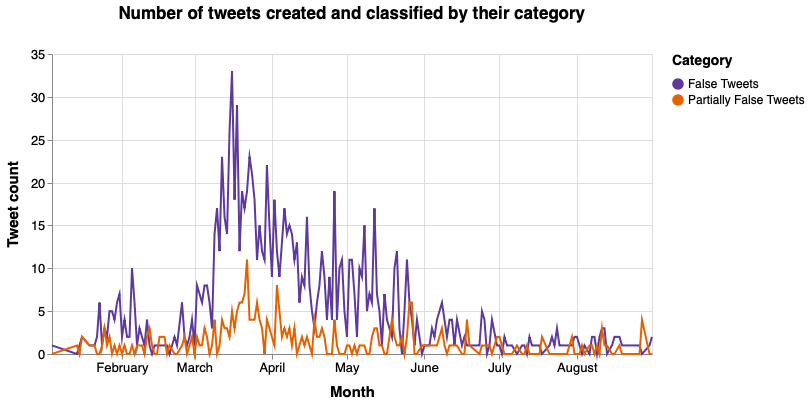